# [Release] 2023 PyTorch Study : Level 2 Chapter 2 - Example
*Copyright 2023. 이호준 all rights reserved.*

-----

「Level 2 Chapter 2 - Perceptron」의 예제 코드입니다.

본 예제 코드의 목적은 Perceptron (퍼셉트론, 단층 신경망)을 통해 "**손글씨로 적힌 숫자를 인식하는 인공지능**"을 만드는 것입니다.

## Import
필요한 라이브러리들을 Import합니다.

|라이브러리 이름|설명|
|---|---|
|torch|PyTorch|
|torchvision|PyTorch의 Computer Vision 부분을 더 자세하게 다루는 라이브러리.|
|Numpy|텐서 연산 라이브러리|
|Matplotlib|데이터 시각화 라이브러리|
|warnings|경고 출력을 지우기 위해 사용하는 라이브러리/|

*warnings은 당장 모르셔도 괜찮습니다.*

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Define Hyper Parameters
학습에 필요한 하이퍼 파라미터(상수)들을 선언합니다.

### 학습 및 테스트 관련 하이퍼 파라미터
|이름|타입|설명|
|---|---|---|
|RANDOM_SEED|Integer|랜덤 시드입니다.|
|BATCH_SIZE|Integer|학습 시 배치 사이즈입니다.|
|TEST_BATCH_SIZE|Integer|테스트 시 배치 사이즈입니다.|
|EPOCHS|Integer|학습 횟수입니다.|
|lr|Float|학습률입니다. "Level 2 Chapter 1 예제"의 ALPHA와 동일한 역할을 합니다.|
|momentum|Float|경사하강법의 성능을 더 높이기 위하여 사용되는 모멘텀입니다. 이름 그대로 관성을 추가해줍니다.|
|log_interval|Integer|학습 중간 중간 학습 현황을 알려주는 로그를 찍어주는 간격입니다.|


### 환경 관련 하이퍼 파라미터

일반적인 인공지능은 GPU에서 연산이 훨씬 빠릅니다. 아래 변수는 해당 사항을 설정해주는 변수입니다.

|이름|설명|
|---|---|
|USE_CUDA|현재 코드가 돌아가고 있는 환경이 GPU가 사용 가능한 환경인지를 반환합니다.|
|device|GPU가 사용 가능하다면 GPU 디바이스를, 아니라면 CPU 디바이스를 담습니다.|
|cpu_device|GPU 사용시 일부 처리 과정을 CPU에서 해야하기에 CPU 디바이스를 담습니다.|

In [3]:
RANDOM_SEED = 2023 # Random Seed입니다.

BATCH_SIZE = 64 #학습 시 배치 사이즈
TEST_BATCH_SIZE = 1000 # 테스트 시 배치 사이즈
EPOCHS = 10

lr = 0.01 # Level 2 Chapter 1의 ALPHA와 동일한 역할을 하는 상수입니다.
momentum = 0.5
log_interval = 200

# 아래는 GPU 설정을 해주는 변수들입니다.
USE_CUDA = torch.cuda.is_available()
print("Device : {0}".format("GPU" if USE_CUDA else "CPU"))
device = torch.device("cuda" if USE_CUDA else "cpu")
cpu_device = torch.device("cpu")

Device : GPU


## Set Random Seed

In [4]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)

print('Random Seed : {0}'.format(RANDOM_SEED))

Random Seed : 2023


## Load Dataset
학습 및 검증용 데이터를 불러옵니다.

모든 이미지 데이터는 28px * 28px의 흑백 이미지이며 각 픽셀은 닫힌 구간 [0, 255] 사이의 정수로 구성되어 있습니다.

학습 시에는 더 나은 성능을 위해 평균 0.5, 표준편차 0.5로 정규화를 합니다.


|기호|타입|설명|
|---|---|---|
|X|이미지|입력으로 들어갈 이미지|
|Y|닫힌 구간 [0, 9]에 속한 정수|이미지를 인식했을 때 나와야 하는 숫자|

In [5]:
transform = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.Normalize((0.5,), (0.5,))])

train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transform), batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True, transform=transform), batch_size=TEST_BATCH_SIZE, shuffle=True)
test_loader_bs1 = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True, transform=transform), batch_size=1, shuffle=True)

## Visualize Datset
데이터를 출력해봅니다.

In [6]:
def torch_tensor_to_plt(img):
    img = img.clone().detach().to(cpu_device).numpy()[0][0]
    return img

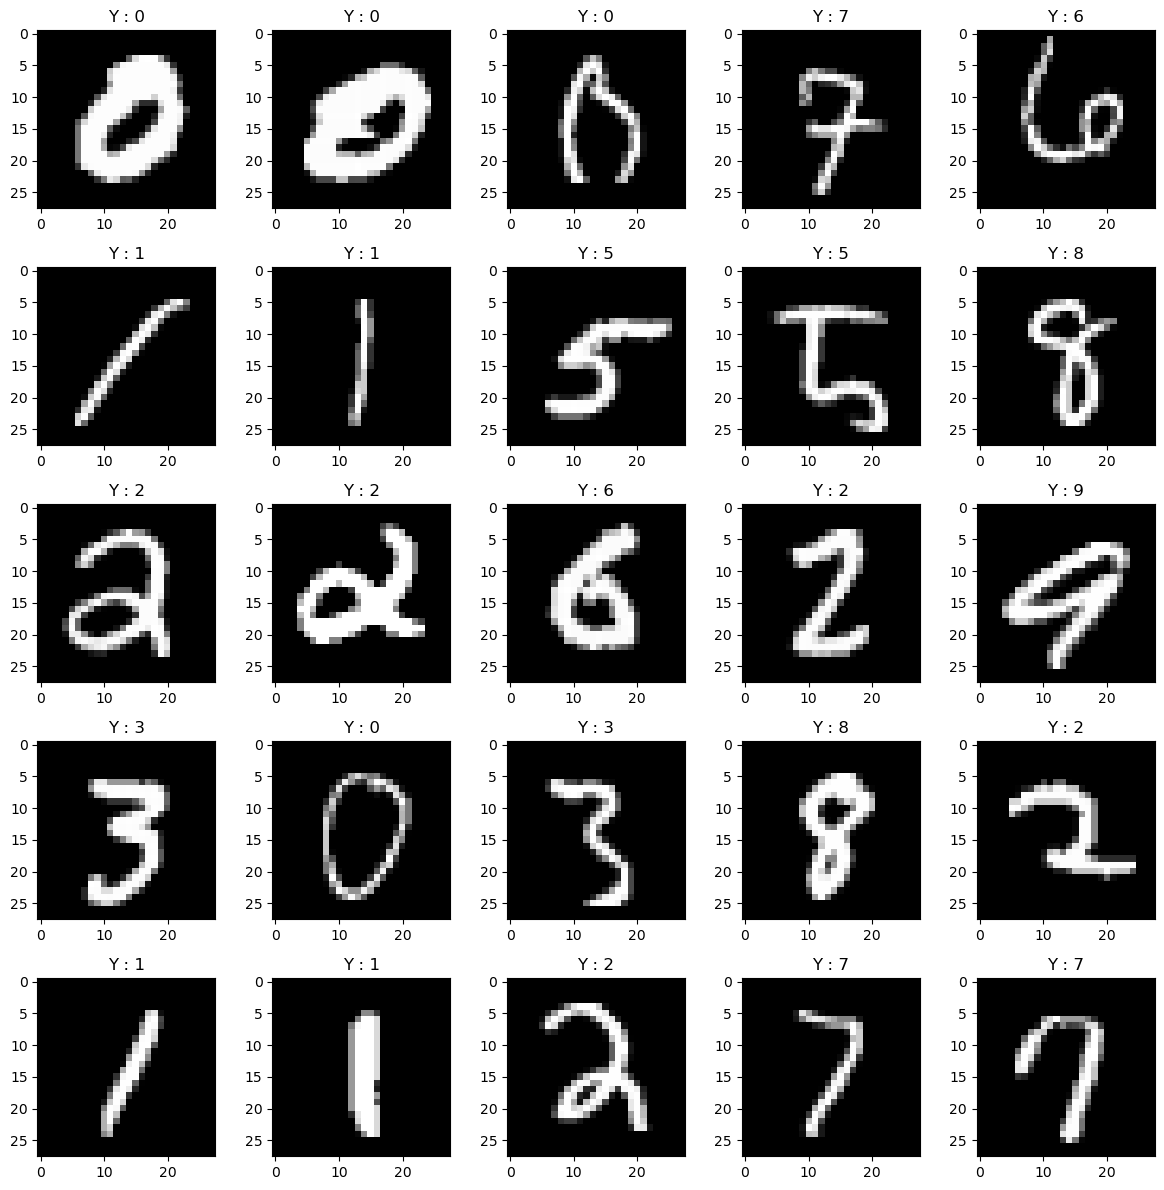

In [7]:
w = 10
h = 10
fig = plt.figure(figsize=(12, 12))

columns = 5
rows = 5

for ind, (data, target) in enumerate(test_loader_bs1):
    i = ind + 1
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.gray()
    plt.imshow(torch_tensor_to_plt(data))
    plt.title('Y : {0}'.format(target[0]))
    if ind+1==columns*rows:
        break
        
plt.show()

## Define Model (Perceptron)

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        y = self.fc(x)
        return F.log_softmax(y, dim=1)

In [9]:
model = Model().to(device)

## Define Optimizer
기본 경사하강법이 아닌, SGD(Stochastic Gradient Descent)라는 업그레이드 된 경사하강법을 옵티마이저로 이용한다.
단 이때 기본 SGD에는 없는 Momentum을 추가한다.

In [10]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

## Define Train Function & Test Function

In [11]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(log_interval, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format
          (test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Train & Test

In [12]:
for epoch in range(1, EPOCHS+1):
    train(log_interval, model, device, train_loader, optimizer, epoch)
    test(log_interval, model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.502942
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.608495
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.510401
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.240217
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.467237

Test set: Average loss: 0.3515, Accuracy: 8995/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.394047
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.238737
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.504272
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.209376
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.322389

Test set: Average loss: 0.3194, Accuracy: 9089/10000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.304193
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.302057
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.293337
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.187237
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.155244

Test set: Average loss: 0.3014, Accuracy: 9152/10000 (92%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.206214
Train Epoch: 4 [12800/60000 (21%)]	Lo

## Real Test

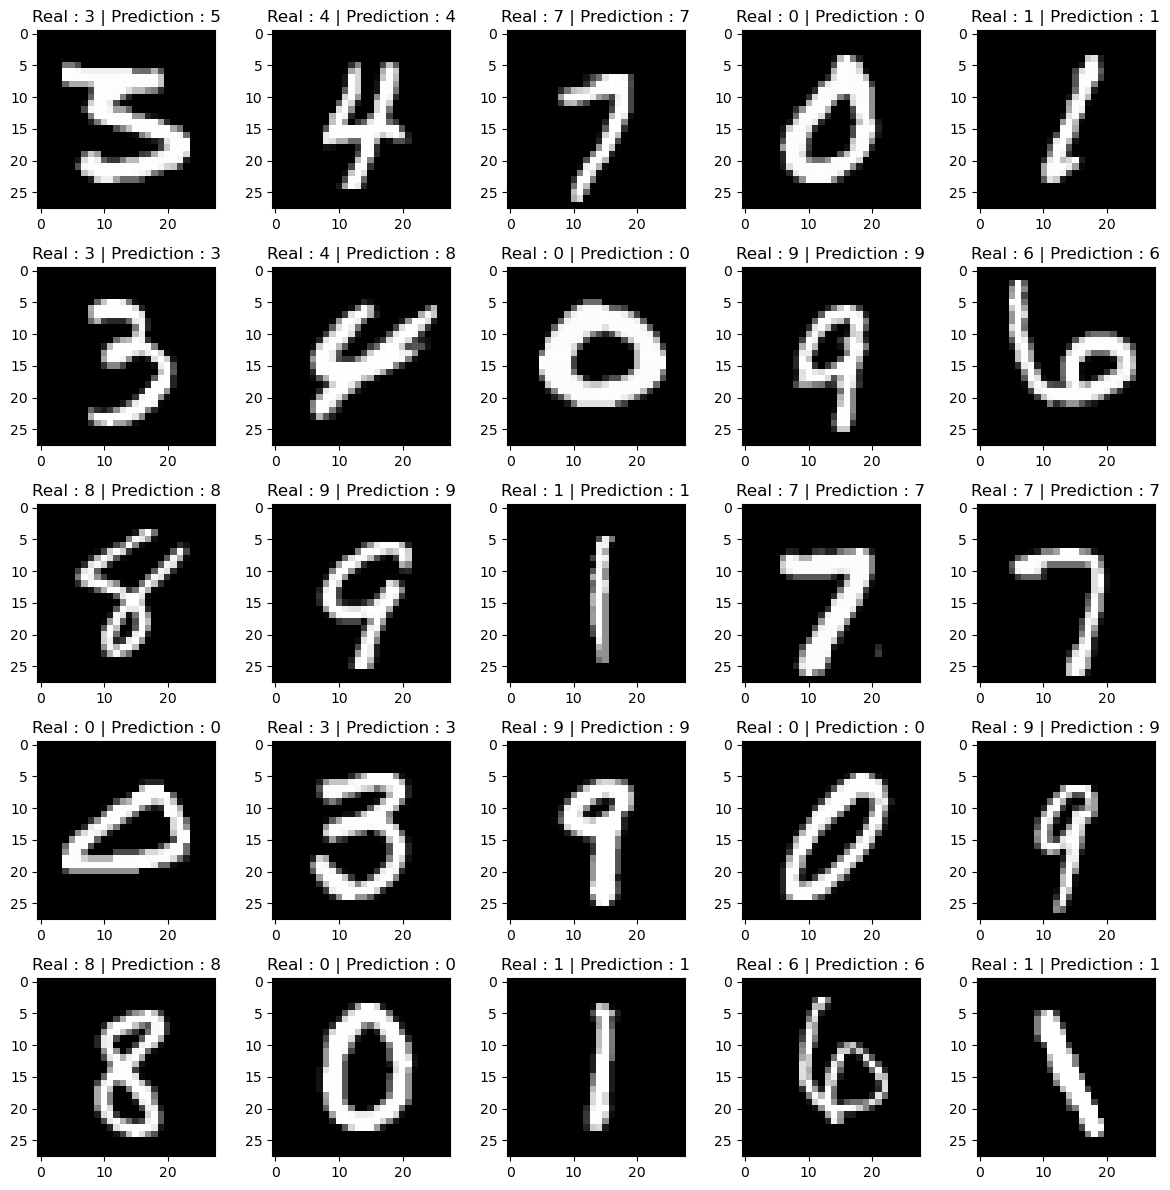

In [13]:
w = 10
h = 10
fig = plt.figure(figsize=(12, 12))

columns = 5
rows = 5

for ind, (data, target) in enumerate(test_loader_bs1):
    data, target = data.to(device), target.to(device)
    output = model(data)
    
    i = ind + 1
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.gray()
    plt.imshow(torch_tensor_to_plt(data))
    plt.title('Real : {0} | Prediction : {1}'.format(target[0], torch.argmax(output[0]).item()))
    if ind+1==columns*rows:
        break
        
plt.show()